In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import warnings
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


import geopandas as gpd
from shapely.geometry import Point, Polygon

# At first we mount the dataset from local file

inputdf = pd.read_csv('Crime.csv')

C:\Users\shawo\AppData\Local\Temp\ipykernel_3916\545881905.py:29: DtypeWarning: Columns (1,18) have mixed types. Specify dtype option on import or set low_memory=False.
  inputdf = pd.read_csv('Crime.csv')


In [2]:


# sneak peak in the data
inputdf.head(2)


,Incident ID,Offence Code,CR Number,Dispatch Date / Time,NIBRS Code,Victims,Crime Name1,Crime Name2,Crime Name3,Police District Name,...,Street Prefix,Street Name,Street Suffix,Street Type,Start_Date_Time,End_Date_Time,Latitude,Longitude,Police District Number,Location
0,201219928,1204,180063894,12/21/2018 09:13:13 PM,120,1,Crime Against Property,Robbery,ROBBERY - STREET-GUN,WHEATON,...,NaN,GEORGIA,NaN,AVE,12/21/2018 09:13:00 PM,NaN,39.03627,-77.0499,4D,"(39.0363, -77.0499)"
1,201301798,5016,200035833,09/13/2020 12:26:58 AM,90Z,1,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,...,NaN,COLTRANE,NaN,DR,08/08/2020 05:10:00 PM,08/08/2020 12:00:00 AM,39.27784,-77.2115,5D,"(39.2778, -77.2115)"


In [3]:
print(inputdf.shape)
# 'column names are:' 
inputdf.columns

(312297, 30)


Index(['Incident ID', 'Offence Code', 'CR Number', 'Dispatch Date / Time',
       'NIBRS Code', 'Victims', 'Crime Name1', 'Crime Name2', 'Crime Name3',
       'Police District Name', 'Block Address', 'City', 'State', 'Zip Code',
       'Agency', 'Place', 'Sector', 'Beat', 'PRA', 'Address Number',
       'Street Prefix', 'Street Name', 'Street Suffix', 'Street Type',
       'Start_Date_Time', 'End_Date_Time', 'Latitude', 'Longitude',
       'Police District Number', 'Location'],
      dtype='object')

Analyzing the dataset, we observe that columns -


* Incident ID
*	Offence Code
* CR Number
* NIBRS Code
* State (All should be MD)
* Sector, Beat, PRA - meaningless
* Address Number (included in "Block Address")
* Street Prefix (lots of missing values)
* Street Suffix (lots of missing values)
* Police District Number (meaningless)
* Location (pair of Latitude and Longitude)

 are unnecessary. So they are removed.

In [4]:
# dropping the unnecessary columns
#inputdf = data
unnecessary_columns = ['Incident ID', 'Offence Code', 'CR Number', 'NIBRS Code', 'State', 'Sector', 'Beat', 'PRA', 'Address Number', 'Street Prefix', 'Street Suffix', 'Police District Number', 'Location'  ]
for i in unnecessary_columns:
  inputdf = inputdf.drop(i, axis=1)
inputdf.head(2)

,Dispatch Date / Time,Victims,Crime Name1,Crime Name2,Crime Name3,Police District Name,Block Address,City,Zip Code,Agency,Place,Street Name,Street Type,Start_Date_Time,End_Date_Time,Latitude,Longitude
0,12/21/2018 09:13:13 PM,1,Crime Against Property,Robbery,ROBBERY - STREET-GUN,WHEATON,11100 BLK GEORGIA AVE,SILVER SPRING,20902.0,MCPD,Street - Bus Stop,GEORGIA,AVE,12/21/2018 09:13:00 PM,NaN,39.03627,-77.0499
1,09/13/2020 12:26:58 AM,1,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,25600 BLK COLTRANE DR,DAMASCUS,20872.0,MCPD,Parking Lot - Residential,COLTRANE,DR,08/08/2020 05:10:00 PM,08/08/2020 12:00:00 AM,39.27784,-77.2115


# Later, Columns related with the effect of crime are removed.

In [5]:
unnecessary_columns = ['Dispatch Date / Time', 'Victims', 'Block Address', 'Street Type', 'Agency', 'Start_Date_Time', 'End_Date_Time']
for i in unnecessary_columns:
  inputdf = inputdf.drop(i, axis=1)
inputdf.head(2)

,Crime Name1,Crime Name2,Crime Name3,Police District Name,City,Zip Code,Place,Street Name,Latitude,Longitude
0,Crime Against Property,Robbery,ROBBERY - STREET-GUN,WHEATON,SILVER SPRING,20902.0,Street - Bus Stop,GEORGIA,39.03627,-77.0499
1,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,DAMASCUS,20872.0,Parking Lot - Residential,COLTRANE,39.27784,-77.2115


Some columns are confusing to be added now. Such as -

* Crime Name3
* Zip Code
* Street Name
* Also we have to take special care of Latitude and Longitude if we want them to include in our feature set.

# Now we have to visualize the data and fix what to predict from these modified feature set

PROJCS["NAD83 / Maryland (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",37.6666666666667],PARAMETER["central_meridian",-77],PARAMETER["standard_parallel_1",38.3],PARAMETER["standard_parallel_2",39.45],PARAMETER["false_easting",1312333.33333333],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


<AxesSubplot:>

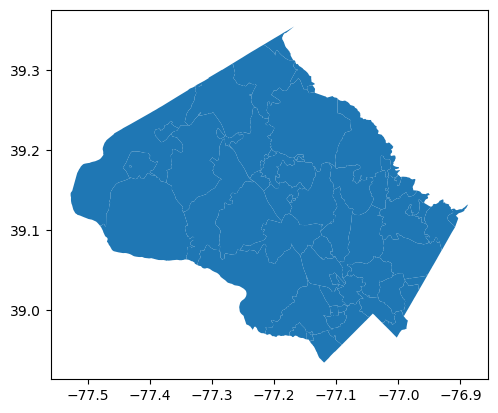

In [6]:
# Montgomery County maintained roads
# https://data.imap.maryland.gov/datasets/maryland::montgomery-county-maintained-roads/explore?location=39.168559%2C-76.905435%2C9.35
# https://catalog.data.gov/dataset/tiger-line-shapefile-2018-county-montgomery-county-md-all-roads-county-based-shapefile
# crs = {'init':'EPSG:4326'}
montgomery_county_map = gpd.read_file('Zipcodes.shp')
print(montgomery_county_map.crs) 
montgomery_county_map.to_crs(epsg=4326).plot()

# Other sources for multiple data view
# https://montgomeryplanning.org/tools/gis-and-mapping/map-library/

# Drop rows from the dataframe based on certain condition applied on a column


<AxesSubplot:>

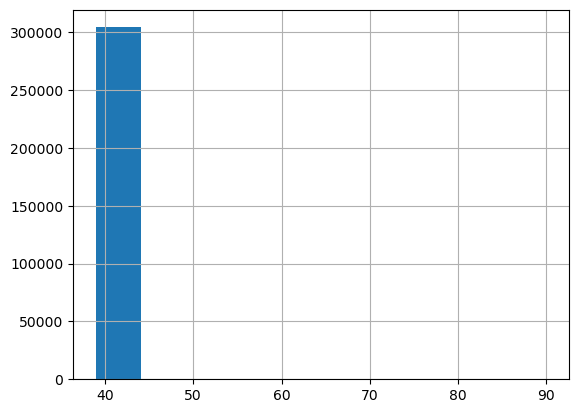

In [7]:
# Filter all rows for Latitude is greater than or equal to 35
inputdf = inputdf[inputdf['Latitude'] > 35.0]
inputdf['Latitude'].hist()

<AxesSubplot:>

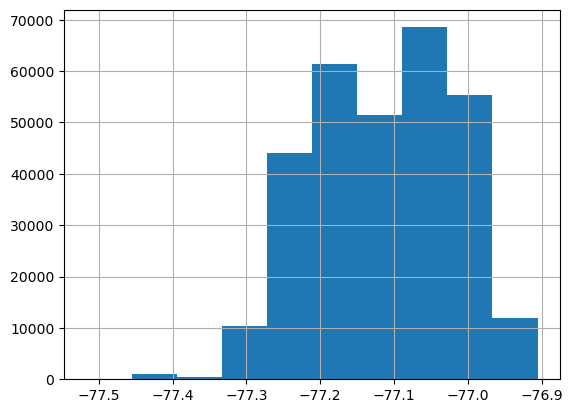

In [8]:
# Filter all rows for Longitude is less than or equal to -70
inputdf = inputdf[inputdf['Longitude'] < -70]
inputdf['Longitude'].hist()

In [9]:
# Export Pandas DataFrame to CSV

inputdf.to_csv('potential feature set revised.csv')


# ‘geo_df’ that is a copy of our original data frame but with the newly created ‘geometry’ column.


In [10]:
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(inputdf['Longitude'], inputdf['Latitude'])]
geo_df = gpd.GeoDataFrame(inputdf, 
                          crs = crs, 
                          geometry = geometry)

geo_df.head()

c:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Crime Name1,Crime Name2,Crime Name3,Police District Name,City,Zip Code,Place,Street Name,Latitude,Longitude,geometry
0,Crime Against Property,Robbery,ROBBERY - STREET-GUN,WHEATON,SILVER SPRING,20902.0,Street - Bus Stop,GEORGIA,39.036270,-77.049900,POINT (-77.04990 39.03627)
1,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,DAMASCUS,20872.0,Parking Lot - Residential,COLTRANE,39.277840,-77.211500,POINT (-77.21150 39.27784)
2,Crime Against Society,Driving Under the Influence,DRIVING UNDER THE INFLUENCE LIQUOR,ROCKVILLE,ROCKVILLE,20850.0,Street - In vehicle,GRANDIN,39.086688,-77.144754,POINT (-77.14475 39.08669)
3,Other,All Other Offenses,LITTERING/TRASH DUMPING,ROCKVILLE,ROCKVILLE,20850.0,Street - Other,GRANDIN,39.086688,-77.144754,POINT (-77.14475 39.08669)
4,Crime Against Property,Shoplifting,LARCENY - SHOPLIFTING,GERMANTOWN,GERMANTOWN,20876.0,Retail - Department/Discount Store,FREDERICK,39.198295,-77.244900,POINT (-77.24490 39.19830)


<AxesSubplot:>

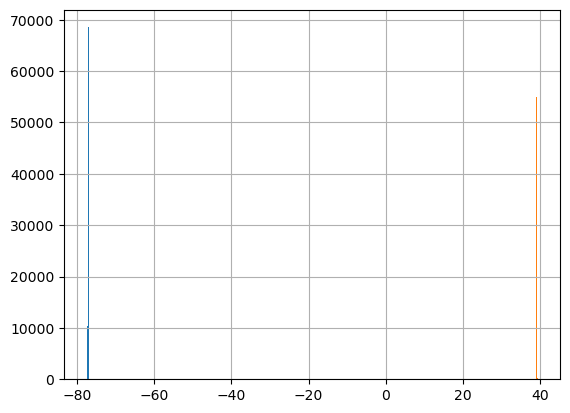

In [11]:
geo_df['Longitude'].hist()
geo_df['Latitude'].hist()

# Visualizing the Crime Data

Text(0.5, 1.0, 'Montgomery County Crime type data Heatmap')

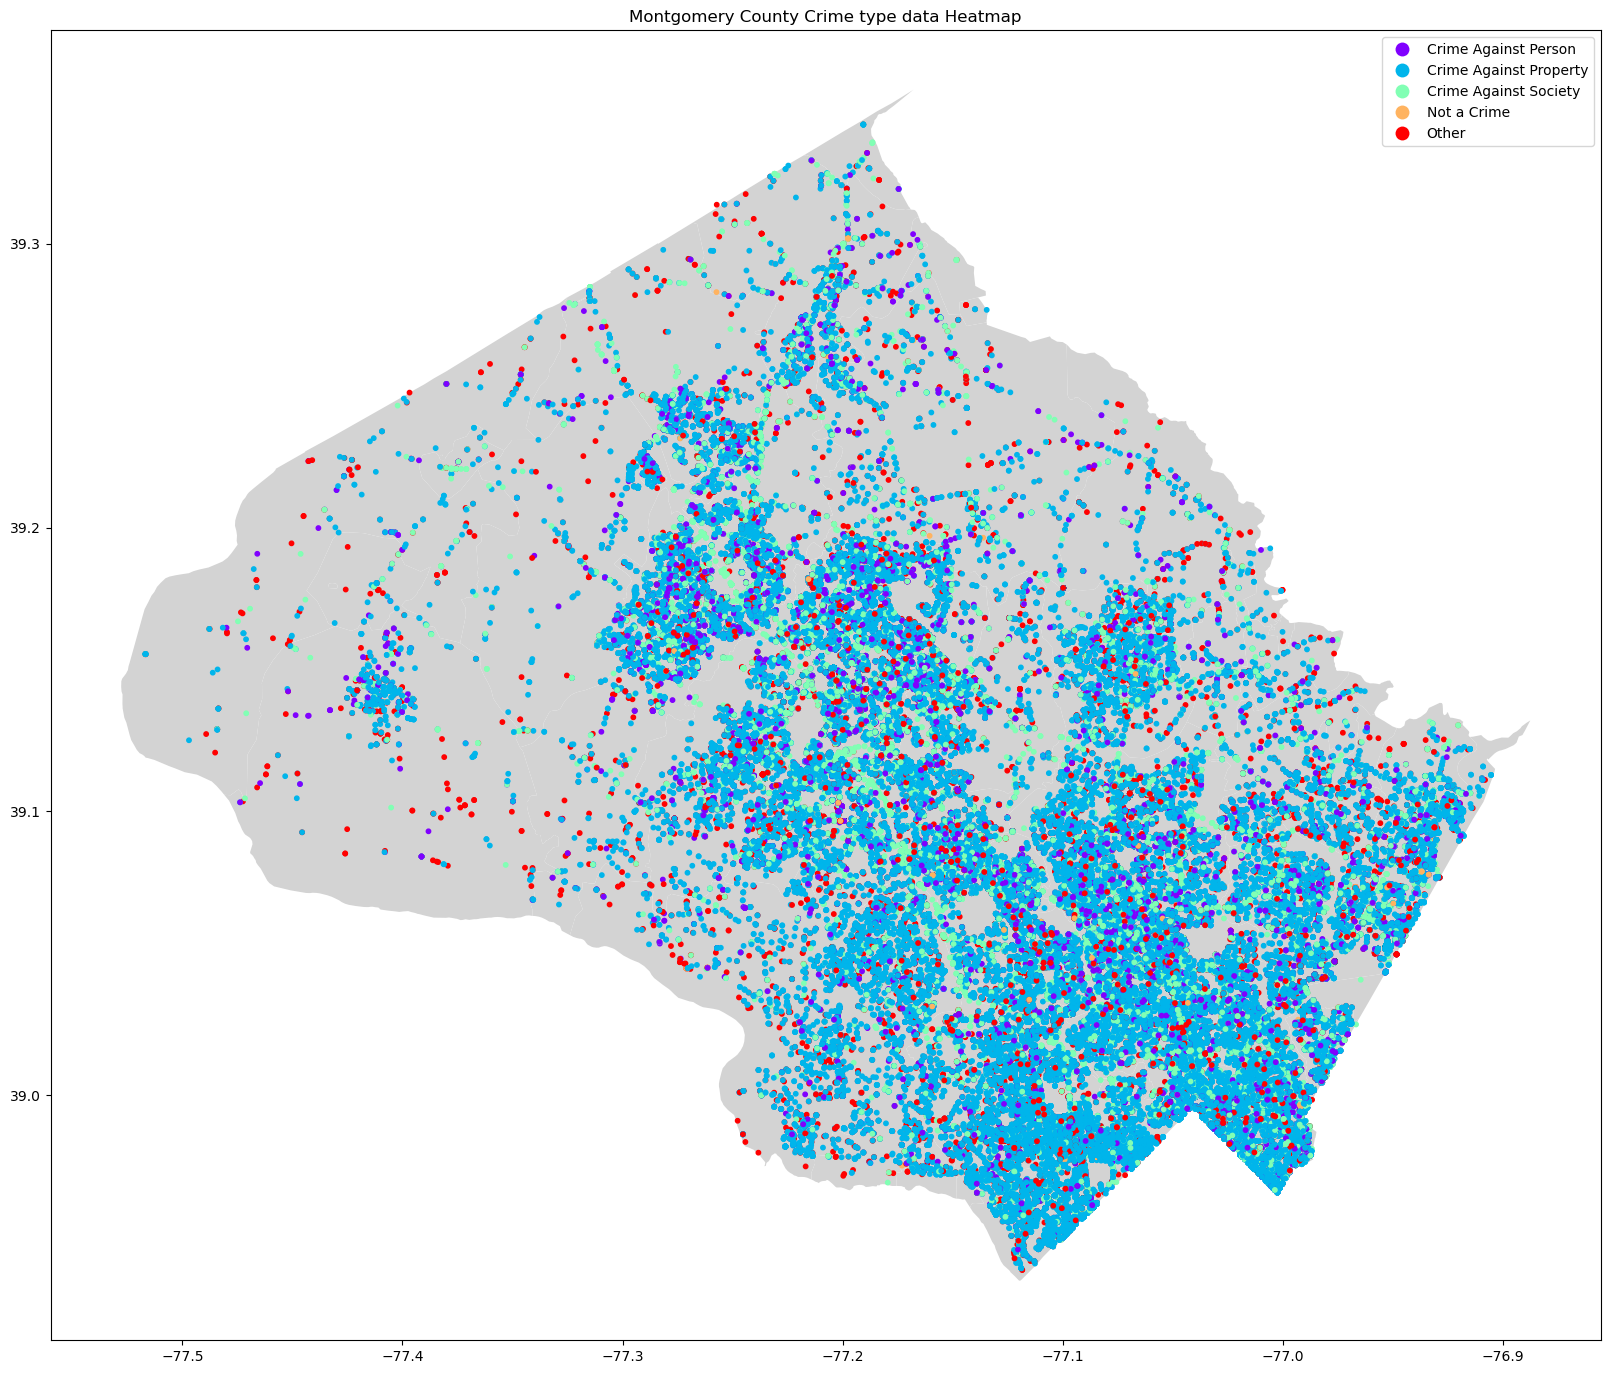

In [12]:
fig, ax = plt.subplots(figsize = (20,20))
montgomery_county_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(column = geo_df['Crime Name1'], ax=ax, cmap = 'rainbow',
            legend = True, #legend_kwds={'shrink': 0.3}, 
            markersize = 10)
ax.set_title('Montgomery County Crime type data Heatmap')
# plt.savefig('Crime Heat Map for Location')

<AxesSubplot:>

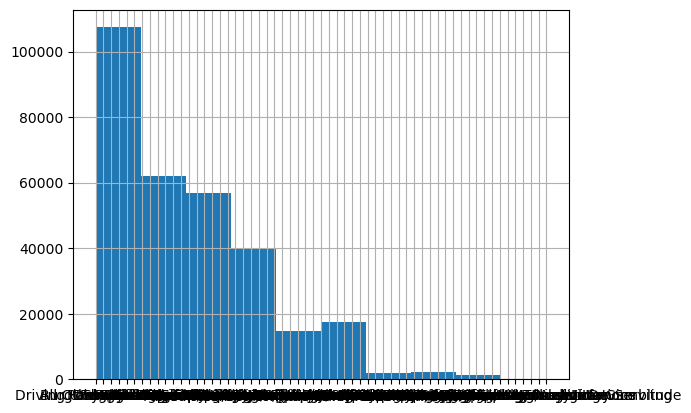

In [13]:
#geo_df['Crime Name1'].hist()
geo_df['Crime Name2'].hist()

# geo_df.groupby('Crime Name2').count() # per group data count


#geo_df['Latitude'].hist()

# Separating Train and Test Set for Crime Prediction for Location

In [14]:
# loc_crime_df = inputdf[['Latitude', 'Longitude', 'Crime Name1']]
loc_crime_df.head()

loc_crime_df.dtypes



Latitude       float64
Longitude      float64
Crime Name1     object
dtype: object

# Transform the data by label encoding

In [15]:
def label_encoder(y):
    le = LabelEncoder()
    loc_crime_df[y] = le.fit_transform(loc_crime_df[y])
 
label_list = ['Latitude', 'Longitude', 'Crime Name1']
 
for l in label_list:
    label_encoder(l)
 
#Display transformed data
loc_crime_df.head()

C:\Users\shawo\AppData\Local\Temp\ipykernel_3916\509106058.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_crime_df[y] = le.fit_transform(loc_crime_df[y])


,Latitude,Longitude,Crime Name1
0,13104,29874,1
1,44589,8415,2
2,23931,16926,2
3,23931,16926,4
4,41734,4967,1


In [16]:
#Divide the dataset into independent and dependent variables
X = loc_crime_df.drop(['Crime Name1'],axis=1)
y = loc_crime_df['Crime Name1']

#Split the data into training and testing set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                               random_state=42, shuffle=True) 

#Data was splitted as 80% train data and 20% test data.

# y_train = y_train.values.reshape(-1,1)
# y_test = y_test.values.reshape(-1,1)

print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

X_train shape: (243340, 2)
X_test shape: (60835, 2)
y_train shape: (243340,)
y_test shape: (60835,)


In [17]:
#Feature Scaling (Standardize the data)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# We will build all six models and compare their accuracy scores.



In [18]:
#To store results of models, we create two dictionaries
result_dict_train = {}
result_dict_test = {}

# Machine Leaning Models and their performance


In [19]:
models = {'Naïve Bayes Classifier': GaussianNB, 'Decision Tree Classifier' : DecisionTreeClassifier, 'KNN Classifier': KNeighborsClassifier,
        'Logistic Regression': LogisticRegression,   'Support Vector Classifier': SVC,
        'Random Forest Classifier': RandomForestClassifier,}
# for keys, values in sorted(models.items()):
#     print(keys +" is "+ values)


# for name, model in models.items():
#     print(name +" is "+ model)
    

In [20]:
# for model_name, model_function in models.items():
#     print(model_name +' is running')
#     try:
#         model = model_function(random_state = 42)
#     except:
#         model = model_function()
#     accuracies = cross_val_score(model, X_train, y_train, cv=5)
#     model.fit(X_train,y_train)
#     y_pred = model.predict(X_test)

#     #Obtain accuracy
#     print("Train Score:",np.mean(accuracies))
#     print("Test Score:",model.score(X_test,y_test))


#     #Store results in the dictionaries
#     result_dict_train['Train Score for '+model_name] = np.mean(accuracies)
#     result_dict_test['Test Score for '+model_name] = model.score(X_test,y_test)


In [21]:
lengthy_models = {'Random Forest Classifier': RandomForestClassifier, 'Support Vector Classifier': SVC}
for model_name, model_function in lengthy_models.items():
    print(model_name +' is running')
    try:
        model = model_function(random_state = 42)
    except:
        model = model_function()
    accuracies = cross_val_score(model, X_train, y_train, cv=5)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    #Obtain accuracy
    print("Train Score:",np.mean(accuracies))
    print("Test Score:",model.score(X_test,y_test))

Random Forest Classifier is running


In [ ]:
lengthy_models = {'Support Vector Classifier': SVC,
        'Random Forest Classifier': RandomForestClassifier}
for model_name, model_function in lengthy_models.items():
    print(model_name +' is running')
    try:
        model = model_function(random_state = 42)
    except:
        model = model_function()
    accuracies = cross_val_score(model, X_train, y_train, cv=5)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    #Obtain accuracy
    print("Train Score:",np.mean(accuracies))
    print("Test Score:",model.score(X_test,y_test))


    # #Store results in the dictionaries
    # result_dict_train['Train Score for '+model_name] = np.mean(accuracies)
    # result_dict_test['Test Score for '+model_name] = model.score(X_test,y_test)

Support Vector Classifier is running


# Compare Accuracy Scores

In [ ]:
df_result_train = pd.DataFrame.from_dict(result_dict_train,orient = "index", columns=["Score"])
print(df_result_train)

df_result_test = pd.DataFrame.from_dict(result_dict_test,orient = "index",columns=["Score"])
df_result_test


                         Score
Logistic Train Score  0.458543


,Score
Logistic Test Score,0.459206


# Display the accuracy scores

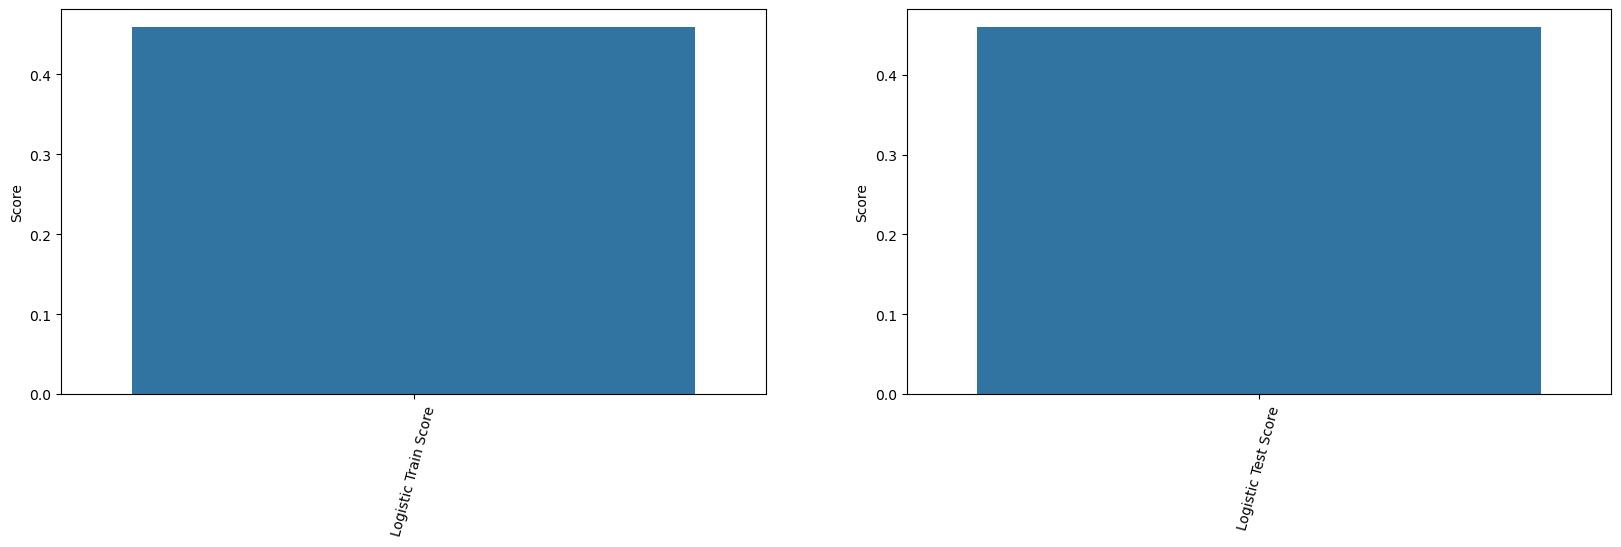

In [ ]:
import seaborn as sns

fig,ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x = df_result_train.index,y = df_result_train.Score,ax = ax[0])
sns.barplot(x = df_result_test.index,y = df_result_test.Score,ax = ax[1])
ax[0].set_xticklabels(df_result_train.index,rotation = 75)
ax[1].set_xticklabels(df_result_test.index,rotation = 75)
plt.show()